# Uganda Power Grid Optimization

This notebook is a pre-processing script that will read in shapefiles and convert to the input to a powergrid optimization model. The input to this model will be in CSVs. We are testing this within Uganda.

## import libraries

In [218]:
import sys, os, inspect, logging, importlib

import geopandas as gpd
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.ops import split, unary_union
from shapely.geometry import box, Point

import matplotlib.pyplot as plt

In [219]:
# Get reference to GOSTNets
sys.path.append(r'../../GOSTNets/GOSTNets')
import GOSTnet as gn

In [220]:
# Define input data and create a number of output datasets if they do not yet exist
inputFolder = r'./input_folder'

input_power_lines_gpd = gpd.read_file(os.path.join(inputFolder, "power_lines.shp"))
input_new_connection_options_gpd = gpd.read_file(os.path.join(inputFolder, "new_connection_options.shp"))
 
input_power_nodes_gpd = gpd.read_file(os.path.join(inputFolder, "power_nodes.shp"))

In [221]:
outputFolder = r'./output_folder'

## Generate the power line networks

### We will read in the power line shapefiles and convert them it to a geodataframe of points. Then the input station points are snapped to these points and the geometries of the stations get changed to match the geometry of the point it was snapped to

## Power Lines

In [222]:
#Read in the input_power_lines for problems, and project

#input_power_lines = input_power_lines[[r is not None for r in inR.geometry]]

#if inR.crs == {'init':'epsg:4326'}:
#    print('skip')
#inR = inR.to_crs({'init': 'epsg:32643'})

# line below not needed because length will be generated at a later step
# inR['length'] = inR['geometry'].apply(lambda x: x.length)

# Read in the power nodes and project
#input_power_nodes = gpd.read_file(input_power_nodes)

#inS = inS[inS['railway'] == "station"]

# inS_proj = inS.to_crs({'init': 'epsg:32643'})
# print('check projection inS')
# print(inS_proj.crs)

# print('check projection inR')
# print(inR.crs)

#Generate the Rail network from the rail shapefile
#allRailLines = unary_union(inR['geometry'])


In [223]:
# deconstructing the power line network into a geodataframe of points
bag_of_points,ids = [],[]
id_ = 0
for r in input_power_lines_gpd.geometry:
    for q in r.coords:
        bag_of_points.append(q)
        ids.append(id_)
        id_+=1

df_temp = pd.DataFrame(({'ids':ids,'geometry':bag_of_points}))
df_temp['geometry'] = df_temp['geometry'].apply(Point)
gdf_temp = gpd.GeoDataFrame(df_temp, crs = input_power_lines_gpd.crs, geometry = 'geometry')

In [224]:

# the source_crs should be the same proj as both the input graph and input geodataframe of points
# the rail points need to be snapped to the rail because later the snapped points will be used to split the rail
input_power_nodes_snapped = gn.pandana_snap_points(input_power_nodes_gpd, 
                                          gdf_temp, 
                                          source_crs = 'epsg:4326', 
                                          target_crs = 'epsg:4326',
                                          add_dist_to_node_col = True)

input_power_nodes_snapped_temp = input_power_nodes_snapped.drop_duplicates('NN')

In [225]:
# I think that when the rail stations got snapped to the nearest node in the dataframe it is keeping the original geometry
# but it is adding the NN id and the NN_distance

# Therefore join to the Rail gdf to add the geometries of the nodes snapped to
input_power_nodes_snapped_temp = input_power_nodes_snapped_temp.rename(columns={"geometry": "original_geometry"})
input_power_nodes_snapped_temp_joined = input_power_nodes_snapped_temp.set_index('NN').join(gdf_temp.set_index('ids'))
input_power_nodes_snapped_temp_joined = input_power_nodes_snapped_temp_joined.reset_index()

In [226]:


# note when I had both original_geometry and geometry columns there was an error in outputting a shapefile
# it must have been confused with two geometry columns, therefore I am dropping the 'original_geometry' column
input_power_nodes_snapped_temp_joined_slim = input_power_nodes_snapped_temp_joined.drop(columns="original_geometry")
input_power_nodes_snapped_temp_joined_slim

,NN,id,demand,NN_dist,geometry
0,1,2,None,0.0,POINT (33.33386 3.34876)
1,3,4,100,0.0,POINT (33.32978 3.37480)
2,5,3,100,0.0,POINT (33.25931 3.30027)
3,11,7,100,0.0,POINT (33.19826 3.31296)
4,7,6,100,0.0,POINT (33.25168 3.37345)
5,9,5,200,0.0,POINT (33.20872 3.26694)
6,0,1,None,0.0,POINT (33.36255 3.29727)


In [227]:


#inS_proj_snapped_temp.keys()

input_power_nodes_snapped_temp_joined_geo = gpd.GeoDataFrame(input_power_nodes_snapped_temp_joined_slim, crs = input_power_lines_gpd.crs, geometry = 'geometry')
# preview the snapped rail stations
input_power_nodes_snapped_temp_joined_geo.to_file(driver = 'ESRI Shapefile', filename = outputFolder + '/snapped_power_nodes.shp')

In [228]:
input_power_nodes_snapped_temp_joined_geo

,NN,id,demand,NN_dist,geometry
0,1,2,None,0.0,POINT (33.33386 3.34876)
1,3,4,100,0.0,POINT (33.32978 3.37480)
2,5,3,100,0.0,POINT (33.25931 3.30027)
3,11,7,100,0.0,POINT (33.19826 3.31296)
4,7,6,100,0.0,POINT (33.25168 3.37345)
5,9,5,200,0.0,POINT (33.20872 3.26694)
6,0,1,None,0.0,POINT (33.36255 3.29727)


## Generate the power network Part II
#### The allRailLines are the result of a unary union on the railway lines. Therefore they are only multiLine geometries without any attribution. The snapped railway stations also undergo a unary union and are now multiPoint. allRailLines gets split by the snapped railway stations and all the parts are put back together creating a MultiDiGraph.

In [229]:
input_power_lines_gpd

,id,capacity,loss_factr,geometry
0,1,1000,0.03,"LINESTRING (33.36255 3.29727, 33.33386 3.34876)"
1,3,500,0.05,"LINESTRING (33.33386 3.34876, 33.32978 3.37480)"
2,2,500,0.05,"LINESTRING (33.33386 3.34876, 33.25931 3.30027)"
3,5,500,0.05,"LINESTRING (33.25931 3.30027, 33.25168 3.37345)"
4,4,500,0.05,"LINESTRING (33.25931 3.30027, 33.20872 3.26694)"
5,7,200,0.07,"LINESTRING (33.32978 3.37480, 33.19826 3.31296)"
6,6,200,0.07,"LINESTRING (33.32978 3.37480, 33.25168 3.37345)"
7,8,200,0.08,"LINESTRING (33.20872 3.26694, 33.19826 3.31296)"


In [230]:
len(input_power_lines_gpd)

8

In [231]:
# if not os.path.exists(outRailGraph):

allPowerLines = unary_union(input_power_lines_gpd['geometry'])

bag_of_relevant_points = unary_union(input_power_nodes_snapped_temp_joined_geo.geometry)

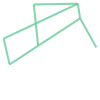

In [232]:
allPowerLines

In [233]:
len(allPowerLines)

10

In [234]:
# oh man, so unary union creates more lines where they intersect. This is not good.

In [235]:
input_power_nodes_snapped_temp_joined_geo

,NN,id,demand,NN_dist,geometry
0,1,2,None,0.0,POINT (33.33386 3.34876)
1,3,4,100,0.0,POINT (33.32978 3.37480)
2,5,3,100,0.0,POINT (33.25931 3.30027)
3,11,7,100,0.0,POINT (33.19826 3.31296)
4,7,6,100,0.0,POINT (33.25168 3.37345)
5,9,5,200,0.0,POINT (33.20872 3.26694)
6,0,1,None,0.0,POINT (33.36255 3.29727)


In [236]:
len(bag_of_relevant_points)

7

In [237]:
print(bag_of_relevant_points)

MULTIPOINT (33.19826147592042 3.312955821872942, 33.20871566336239 3.266935148223899, 33.25167789484355 3.373451146608405, 33.25931203326864 3.300273927870942, 33.32978257461352 3.374795444645558, 33.33385735159716 3.348764698405603, 33.3625506299193 3.297271242490783)


In [238]:
# a shapely.ops function
split_geoms = split(allPowerLines, bag_of_relevant_points)

print('print count of split geometries')
print(len(split_geoms))

geom_bag = []

for geom in split_geoms:
    g = geom.coords[0]
    h = geom.coords[-1]
    geom_bag.append(str(g))
    geom_bag.append(str(h))
    print(geom)


print count of split geometries
10
LINESTRING (33.32978257461352 3.374795444645558, 33.25167789484355 3.373451146608405)
LINESTRING (33.20871566336239 3.266935148223899, 33.19826147592042 3.312955821872942)
LINESTRING (33.3625506299193 3.297271242490783, 33.33385735159716 3.348764698405603)
LINESTRING (33.25931203326864 3.300273927870942, 33.20871566336239 3.266935148223899)
LINESTRING (33.33385735159716 3.348764698405603, 33.25931203326864 3.300273927870942)
LINESTRING (33.25931203326864 3.300273927870942, 33.25519625070665 3.339725861284189)
LINESTRING (33.25519625070665 3.339725861284189, 33.19826147592042 3.312955821872942)
LINESTRING (33.25519625070665 3.339725861284189, 33.25167789484355 3.373451146608405)
LINESTRING (33.32978257461352 3.374795444645558, 33.25519625070665 3.339725861284189)
LINESTRING (33.33385735159716 3.348764698405603, 33.32978257461352 3.374795444645558)


In [239]:

ref = pd.DataFrame({'node_ids':range(0, len(geom_bag)),'geoms':geom_bag})
ref = ref.drop_duplicates('geoms')
ref = ref.set_index('geoms')

nodes = []
edges = []

for geom in split_geoms:
    u_data,v_data,edge_data = {},{},{}

    # start node
    # it is getting a reference to that node's coords
    u = ref['node_ids'].loc[str(geom.coords[0])]
    u_data['x'] = geom.coords[0][0]
    u_data['y'] = geom.coords[0][1]
    u_data['geom'] = Point(geom.coords[0])
    #u_data['string'] = str(geom.coords[0])

    # end node
    v = ref['node_ids'].loc[str(geom.coords[-1])]
    v_data['x'] = geom.coords[-1][0]
    v_data['y'] = geom.coords[-1][1]
    v_data['geom'] = Point(geom.coords[-1])
    #v_data['string'] = str(geom.coords[-1])

    # edge
    edge_data['geom'] = geom
    edge_data['length'] = geom.length
    #edge_data['rail_type'] = geom.rail_type

    nodes.append((u,u_data))
    nodes.append((v,v_data))
    edges.append((u,v,edge_data))
    edges.append((v,u,edge_data))

    id_ += 2

G_PowerLines = nx.MultiDiGraph()
G_PowerLines.add_nodes_from(nodes)
G_PowerLines.add_edges_from(edges)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [240]:
len(nodes)

20

In [241]:
# why is there 8?
G_PowerLines.number_of_nodes()

8

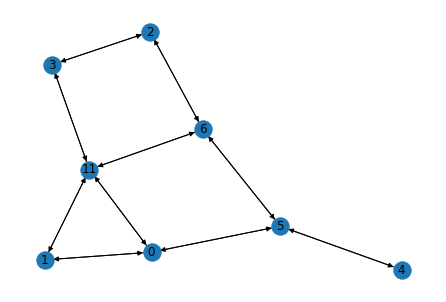

In [242]:
nx.draw(G_PowerLines, with_labels = True)

#### you can see below that the edges only have the geometry and the length attributes

In [243]:
gn.example_edge(G_PowerLines, 3)

(0, 1, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c3ae023c8>, 'length': 0.07811624760049216})
(0, 11, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c388be2e8>, 'length': 0.08241962988924229})
(0, 5, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c388be390>, 'length': 0.026347742925635312})


In [244]:
gn.example_node(G_PowerLines, 8)

(0, {'x': 33.32978257461352, 'y': 3.3747954446455584, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be400>})
(1, {'x': 33.25167789484355, 'y': 3.3734511466084047, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be2b0>})
(2, {'x': 33.20871566336239, 'y': 3.2669351482238986, 'geom': <shapely.geometry.point.Point object at 0x7f9c38d69320>})
(3, {'x': 33.19826147592042, 'y': 3.312955821872942, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be080>})
(4, {'x': 33.362550629919305, 'y': 3.2972712424907833, 'geom': <shapely.geometry.point.Point object at 0x7f9c388f2c88>})
(5, {'x': 33.33385735159716, 'y': 3.348764698405603, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be3c8>})
(6, {'x': 33.259312033268635, 'y': 3.300273927870942, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be198>})
(11, {'x': 33.25519625070665, 'y': 3.339725861284189, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be358>})


#### you can see below that there is an additional attribute 'rail_type' that we would like to add to the edges

In [245]:
input_power_lines_gpd[:5]

,id,capacity,loss_factr,geometry
0,1,1000,0.03,"LINESTRING (33.36255 3.29727, 33.33386 3.34876)"
1,3,500,0.05,"LINESTRING (33.33386 3.34876, 33.32978 3.37480)"
2,2,500,0.05,"LINESTRING (33.33386 3.34876, 33.25931 3.30027)"
3,5,500,0.05,"LINESTRING (33.25931 3.30027, 33.25168 3.37345)"
4,4,500,0.05,"LINESTRING (33.25931 3.30027, 33.20872 3.26694)"


### Find all edges that intersect the input railways and where they do add the attributes to the edges

In [246]:
#if not os.path.exists(outRailGraph):

# Remember that this is a MultiDiGraph so there are two directed edges between each pair of nodes. 
graph_edge_count = 0
graph_edge_intersects = 0
graph_edge_no_intersects = 0

# loop through each edge in the graph
for edge in G_PowerLines.edges(data=True):
    graph_edge_count += 1
    # loop through each power line in the input railway geodataframe
    for row in input_power_lines_gpd.itertuples(index=False):
        # if there is an intersection
        if edge[2]['geom'].intersects(row.geometry):
            # print("an intersection has occurred")
            graph_edge_intersects += 1
            # for the edge add all the attributes that are not length or geometry
            row_dict = row._asdict()
            for name,value in row_dict.items():
                if not (name=='geometry' or name=='length'):
                    #print(name)
                    # This updates the edge and adds a new attribute key and value
                    #G_rail[edge[0]][edge[1]][0].update(name=value)
                    G_PowerLines[edge[0]][edge[1]][0][name]=value
        else:
            graph_edge_no_intersects += 1

#nx.write_gpickle(G_PowerLines, outPowerLinesGraph)

    
    #else:
#    G_rail = nx.read_gpickle(outPowerLinesGraph) 
    
print(graph_edge_count)
print(graph_edge_intersects)
print(graph_edge_no_intersects)

20
72
88


### Find all nodes that intersect the input nodes and where they do add the attributes to the nodes

In [247]:
input_power_nodes_snapped_temp_joined_geo

,NN,id,demand,NN_dist,geometry
0,1,2,None,0.0,POINT (33.33386 3.34876)
1,3,4,100,0.0,POINT (33.32978 3.37480)
2,5,3,100,0.0,POINT (33.25931 3.30027)
3,11,7,100,0.0,POINT (33.19826 3.31296)
4,7,6,100,0.0,POINT (33.25168 3.37345)
5,9,5,200,0.0,POINT (33.20872 3.26694)
6,0,1,None,0.0,POINT (33.36255 3.29727)


In [248]:
for n in G_PowerLines.nodes(data = True):
    print(n)
    #print(n[0])
    #print(G_PowerLines.nodes[n[0]]['x'])

(0, {'x': 33.32978257461352, 'y': 3.3747954446455584, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be400>})
(1, {'x': 33.25167789484355, 'y': 3.3734511466084047, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be2b0>})
(2, {'x': 33.20871566336239, 'y': 3.2669351482238986, 'geom': <shapely.geometry.point.Point object at 0x7f9c38d69320>})
(3, {'x': 33.19826147592042, 'y': 3.312955821872942, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be080>})
(4, {'x': 33.362550629919305, 'y': 3.2972712424907833, 'geom': <shapely.geometry.point.Point object at 0x7f9c388f2c88>})
(5, {'x': 33.33385735159716, 'y': 3.348764698405603, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be3c8>})
(6, {'x': 33.259312033268635, 'y': 3.300273927870942, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be198>})
(11, {'x': 33.25519625070665, 'y': 3.339725861284189, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be358>})


In [249]:
for node in G_PowerLines.nodes(data=True):
    #print(node)
    # loop through each power node in the input power node geodataframe
    for row in input_power_nodes_snapped_temp_joined_geo.itertuples(index=False):
        # if there is an intersection
        if node[1]['geom'].intersects(row.geometry):
            # print('match')
            # for the node add all the attributes that are not geometry
            row_dict = row._asdict()
            for name,value in row_dict.items():
                if not (name == 'geometry'):
                    #print(name)
                    #print(G_PowerLines.node[node])
                    # This updates the node and adds a new attribute key and value
                    #G_rail[edge[0]][edge[1]][0].update(name=value)
                    #G_PowerLines[node[1]][name] = value
                    G_PowerLines.nodes[node[0]][name] = value

In [250]:
gn.example_node(G_PowerLines, 11)

(0, {'x': 33.32978257461352, 'y': 3.3747954446455584, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be400>, 'NN': 3, 'id': 4, 'demand': '100', 'NN_dist': 0.0})
(1, {'x': 33.25167789484355, 'y': 3.3734511466084047, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be2b0>, 'NN': 7, 'id': 6, 'demand': '100', 'NN_dist': 0.0})
(2, {'x': 33.20871566336239, 'y': 3.2669351482238986, 'geom': <shapely.geometry.point.Point object at 0x7f9c38d69320>, 'NN': 9, 'id': 5, 'demand': '200', 'NN_dist': 0.0})
(3, {'x': 33.19826147592042, 'y': 3.312955821872942, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be080>, 'NN': 11, 'id': 7, 'demand': '100', 'NN_dist': 0.0})
(4, {'x': 33.362550629919305, 'y': 3.2972712424907833, 'geom': <shapely.geometry.point.Point object at 0x7f9c388f2c88>, 'NN': 0, 'id': 1, 'demand': None, 'NN_dist': 0.0})
(5, {'x': 33.33385735159716, 'y': 3.348764698405603, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be3c8>, 'NN': 1, 'id': 2, 'demand':

In [251]:
# you can see that the attributes have been added to the graph
for edge in G_PowerLines.edges(data=True):
    print(edge)
    #print(edge[2])

(0, 1, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c3ae023c8>, 'length': 0.07811624760049216, 'id': 6, 'capacity': 200, 'loss_factr': 0.07})
(0, 11, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c388be2e8>, 'length': 0.08241962988924229, 'id': 6, 'capacity': 200, 'loss_factr': 0.07})
(0, 5, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c388be390>, 'length': 0.026347742925635312, 'id': 6, 'capacity': 200, 'loss_factr': 0.07})
(1, 0, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c3ae023c8>, 'length': 0.07811624760049216, 'id': 6, 'capacity': 200, 'loss_factr': 0.07})
(1, 11, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c388be240>, 'length': 0.03390831311314645, 'id': 6, 'capacity': 200, 'loss_factr': 0.07})
(2, 3, {'geom': <shapely.geometry.linestring.LineString object at 0x7f9c3ae02a20>, 'length': 0.047193139736445046, 'id': 8, 'capacity': 200, 'loss_factr': 0.08})
(2, 6, {'geom': <shapely.geome

## visualize network

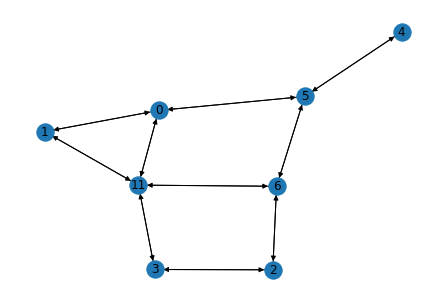

In [252]:
nx.draw(G_PowerLines, with_labels = True)

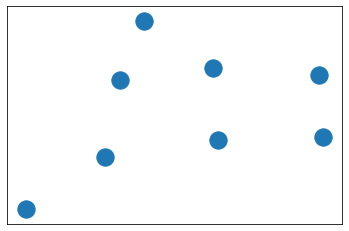

In [253]:
nx.draw_networkx_nodes(G_PowerLines, nx.spring_layout(G_PowerLines))

{0: Text(-0.03220758528430039, -0.3714501884105765, '0'),
 1: Text(0.3573223652120972, -0.5302669817337659, '1'),
 2: Text(0.28567246430169596, 0.6364896126267535, '2'),
 3: Text(0.6066250435140079, 0.36606169316228937, '3'),
 4: Text(-1.0, -0.18134995547116375, '4'),
 5: Text(-0.4818922006186191, -0.10370798017668462, '5'),
 6: Text(-0.05179459219988593, 0.2536560439811983, '6'),
 11: Text(0.3162745050750041, -0.06943224397805049, '11')}

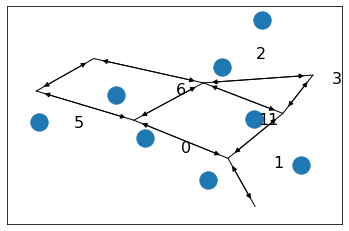

In [254]:
nx.draw_networkx_nodes(G_PowerLines, nx.spring_layout(G_PowerLines))
nx.draw_networkx_edges(G_PowerLines, nx.spring_layout(G_PowerLines))
nx.draw_networkx_labels(G_PowerLines,nx.spring_layout(G_PowerLines), font_size=16)

## For each node in the graph I need to find the neighbors to fill out that matrix

In [255]:
for node in G_PowerLines.nodes():
    print(node)

0
1
2
3
4
5
6
11


In [256]:
print(list(G_PowerLines.neighbors(1)))

[0, 11]


In [257]:
for n in G_PowerLines.nodes(data = True):
    # from node
    print('node:')
    print(G_PowerLines.nodes[n[0]])
    #print(list(G_PowerLines.neighbors(n[0])))
    # print entries in the list
    #for entry in list(G_PowerLines.neighbors(n[0])):
    #    print(entry)
    #    print(G_PowerLines.nodes[entry])

node:
{'x': 33.32978257461352, 'y': 3.3747954446455584, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be400>, 'NN': 3, 'id': 4, 'demand': '100', 'NN_dist': 0.0}
node:
{'x': 33.25167789484355, 'y': 3.3734511466084047, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be2b0>, 'NN': 7, 'id': 6, 'demand': '100', 'NN_dist': 0.0}
node:
{'x': 33.20871566336239, 'y': 3.2669351482238986, 'geom': <shapely.geometry.point.Point object at 0x7f9c38d69320>, 'NN': 9, 'id': 5, 'demand': '200', 'NN_dist': 0.0}
node:
{'x': 33.19826147592042, 'y': 3.312955821872942, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be080>, 'NN': 11, 'id': 7, 'demand': '100', 'NN_dist': 0.0}
node:
{'x': 33.362550629919305, 'y': 3.2972712424907833, 'geom': <shapely.geometry.point.Point object at 0x7f9c388f2c88>, 'NN': 0, 'id': 1, 'demand': None, 'NN_dist': 0.0}
node:
{'x': 33.33385735159716, 'y': 3.348764698405603, 'geom': <shapely.geometry.point.Point object at 0x7f9c388be3c8>, 'NN': 1, 'id': 2, 'd

In [258]:
# get edge between 2 nodes
G_PowerLines.get_edge_data(1,0)

{0: {'geom': <shapely.geometry.linestring.LineString at 0x7f9c3ae023c8>,
  'length': 0.07811624760049216,
  'id': 6,
  'capacity': 200,
  'loss_factr': 0.07}}

In [261]:
# let's try something different where we will read the shapefiles from NetworkX
G1 = nx.read_shp(os.path.join(inputFolder, "import_shp_files/"))

In [262]:
G1

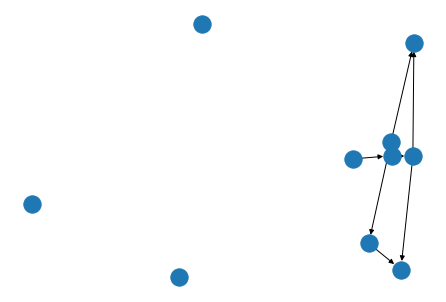

In [264]:
nx.draw(G1)

In [265]:
type(G1)

networkx.classes.digraph.DiGraph

In [269]:
G1_graph = G1.to_undirected()

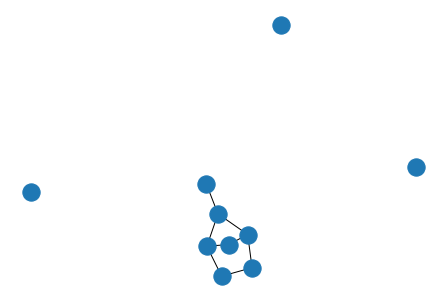

In [270]:
nx.draw(G1_graph)

In [271]:
type(G1_graph)

networkx.classes.graph.Graph

In [272]:
for n in G1_graph.nodes(data = True):
    # from node
    print('node:')
    print(n)
    #print(G1_graph.nodes[n[0]])

node:
((33.362550629919305, 3.2972712424907833), {'id': 1, 'demand': None, 'ShpName': 'power_nodes'})
node:
((33.33385735159716, 3.348764698405603), {'id': 2, 'demand': None, 'ShpName': 'power_nodes'})
node:
((33.32978257461352, 3.3747954446455584), {'id': 4, 'demand': '100', 'ShpName': 'power_nodes'})
node:
((33.259312033268635, 3.300273927870942), {'id': 3, 'demand': '100', 'ShpName': 'power_nodes'})
node:
((33.25167789484355, 3.3734511466084047), {'id': 6, 'demand': '100', 'ShpName': 'power_nodes'})
node:
((33.20871566336239, 3.2669351482238986), {'id': 5, 'demand': '200', 'ShpName': 'power_nodes'})
node:
((33.19826147592042, 3.312955821872942), {'id': 7, 'demand': '100', 'ShpName': 'power_nodes'})
node:
((33.35671522281005, 3.3958558706001303), {'id': 8, 'demand': '100', 'ShpName': 'power_nodes'})
node:
((33.231029531226206, 3.255145722521551), {'id': 9, 'demand': '100', 'ShpName': 'power_nodes'})
node:
((33.278610543040095, 3.2484234015116127), {'id': 10, 'demand': '100', 'ShpName

In [273]:
for e in G1_graph.edges(data = True):
    print(e)

((33.362550629919305, 3.2972712424907833), (33.33385735159716, 3.348764698405603), {'id': 1, 'capacity': 1000, 'loss_factr': 0.03, 'ShpName': 'power_lines', 'Wkb': b'\x00\x00\x00\x00\x02\x00\x00\x00\x02@@\xaeh\x0f\x1dR\xe5@\n`\xcf\xbe\xc4PH@@\xaa\xbb\xd6sQ\xca@\n\xcaE%m6\x01', 'Wkt': 'LINESTRING (33.3625506299193 3.29727124249078,33.3338573515972 3.3487646984056)', 'Json': '{ "type": "LineString", "coordinates": [ [ 33.362550629919305, 3.297271242490783 ], [ 33.33385735159716, 3.348764698405603 ] ] }'})
((33.33385735159716, 3.348764698405603), (33.32978257461352, 3.3747954446455584), {'id': 3, 'capacity': 500, 'loss_factr': 0.05, 'ShpName': 'power_lines', 'Wkb': b'\x00\x00\x00\x00\x02\x00\x00\x00\x02@@\xaa\xbb\xd6sQ\xca@\n\xcaE%m6\x01@@\xaa6P\xbe`\xbc@\n\xff\x94\xc1\x0b\x8a$', 'Wkt': 'LINESTRING (33.3338573515972 3.3487646984056,33.3297825746135 3.37479544464556)', 'Json': '{ "type": "LineString", "coordinates": [ [ 33.33385735159716, 3.348764698405603 ], [ 33.329782574613517, 3.374795

In [278]:
for n in G1_graph.nodes(data = True):
    # from node
    print('node:')
    print(G1_graph.nodes[n[0]])
    #print(list(G1_graph.neighbors(n[0])))
    # print entries in the list
    print('node neighbors:')
    for entry in list(G1_graph.neighbors(n[0])):
        print(entry)
        print(G1_graph.nodes[entry])

node:
{'id': 1, 'demand': None, 'ShpName': 'power_nodes'}
node neighbors:
(33.33385735159716, 3.348764698405603)
{'id': 2, 'demand': None, 'ShpName': 'power_nodes'}
node:
{'id': 2, 'demand': None, 'ShpName': 'power_nodes'}
node neighbors:
(33.362550629919305, 3.2972712424907833)
{'id': 1, 'demand': None, 'ShpName': 'power_nodes'}
(33.32978257461352, 3.3747954446455584)
{'id': 4, 'demand': '100', 'ShpName': 'power_nodes'}
(33.259312033268635, 3.300273927870942)
{'id': 3, 'demand': '100', 'ShpName': 'power_nodes'}
node:
{'id': 4, 'demand': '100', 'ShpName': 'power_nodes'}
node neighbors:
(33.33385735159716, 3.348764698405603)
{'id': 2, 'demand': None, 'ShpName': 'power_nodes'}
(33.19826147592042, 3.312955821872942)
{'id': 7, 'demand': '100', 'ShpName': 'power_nodes'}
(33.25167789484355, 3.3734511466084047)
{'id': 6, 'demand': '100', 'ShpName': 'power_nodes'}
node:
{'id': 3, 'demand': '100', 'ShpName': 'power_nodes'}
node neighbors:
(33.33385735159716, 3.348764698405603)
{'id': 2, 'demand